# Dynamics 365 Business Central Troubleshooting Guide (TSG) - AppSource Submission Results (SaaS)

This notebook contains Kusto queries that can help analyzing the results of the technical validation of your AppSource submission.

NB! The signal used in this notebook is only available starting from October 2021 when the fully automated technical validation was released.

## 1\. Get setup: Load up Python libraries and connect to Application Insights

First you need to set the notebook Kernel to Python3, load the KQLmagic module (did you install it?) and connect to your Application Insights resource (get appid and appkey from the API access page in the Application Insights portal)


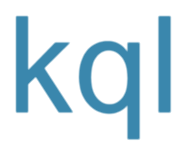

In [1]:
# load the KQLmagic module
%reload_ext Kqlmagic

In [ ]:
# Connect to the Application Insights API
# %kql appinsights://appid='f662fc55-56e4-49d0-b54a-909a76d41a1a';appkey='obgtl5wsg8i7c1w85q488ei8jj1spomoh1wdealz'
%kql appinsights://appid='5320f363-af54-4d91-af03-2a0e4fee2dbd';appkey='yetjaorz5bo4ntbjwxuu7oc2q4vjt8hyn5fhj6u5'

## 2\. Define filters

This workbook is designed for analyzing a single submission. Please provide a value for the validationRequestId. This ID is provided in Partner Center UI if your submission has failed at the automated validation step.

In [2]:
# Validation Request Id
validationRequestId = "<add validation request ID>"

# Date filters for the analysis
# use YYYY-MM-DD format for the dates (ISO 8601)
startDate = "2021-10-01"
endDate = "2021-12-31"

print("Using these parameters for the analysis:")
print("----------------------------------------")
print("validationRequestId " + validationRequestId)
print("startDate           " + startDate)
print("endDate             " + endDate)

Using these parameters for the analysis:
----------------------------------------
validationRequestId <add validation request ID>
startDate           2021-10-01
endDate             2021-12-31


# Analyze the technical validation results

Now you can run Kusto queries to look for your validation results.

This notebooks allows you to find:

- which extensions have been validated 
- which country/regions have been validated
- which releases of Business Central have been validated
- which diagnostics have been reported during the validation
- which baseline extensions have been used during the validation
- which dependency extensions have been used during the validation

Either click **Run All** above to run all sections, or scroll down to the type of analysis you want to do and manually run queries.  

Documentation of the AppSource Submission Signals: [https://learn.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-appsource-submission-validation-trace](https://learn.microsoft.com/en-us/dynamics365/business-central/dev-itpro/administration/telemetry-appsource-submission-validation-trace)

## Technical Validation Process

As part of the technical validation, all extensions in your submission are validated for all the country/regions and releases targeted.

For each combinaison of target country/region and release, your extensions are compiled with the AL compiler and the AppSourceCop analyzer against the dependencies available for the country/region. Additional checks are also performed by the validation service itself (for instance, verifying that the runtime version in the manifest of the extensions is compatible with the releases targeted by your submission).

Documentation of the Technical Validation Checklist: [https://learn.microsoft.com/en-us/dynamics365/business-central/dev-itpro/developer/devenv-checklist-submission](https://learn.microsoft.com/en-us/dynamics365/business-central/dev-itpro/developer/devenv-checklist-submission)

Documentation of the AppSourceCop code analyzer: [https://learn.microsoft.com/en-us/dynamics365/business-central/dev-itpro/developer/analyzers/appsourcecop](https://learn.microsoft.com/en-us/dynamics365/business-central/dev-itpro/developer/analyzers/appsourcecop)

## Extensions validated for your submission

The list of extensions validated for your submission is specified when creating the offer in Partner Center.

In [ ]:
%%kql
let _validationRequestId = validationRequestId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where timestamp between (todatetime(_startDate) .. todatetime(_endDate))   
    and customDimensions.validationRequestId == _validationRequestId
    and customDimensions.eventId == 'LC0028'
| project extensions = customDimensions.extensions

If the list of extensions does not match your expectations, verify the files you have uploaded on the tab 'Configuration' of your offer in Partner Center.

## Countries/regions validated for your submission

The list of countries/regions validated for your submission is specified when creating the offer in Partner Center.

In [ ]:
%%kql
let _validationRequestId = validationRequestId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where timestamp between (todatetime(_startDate) .. todatetime(_endDate))   
    and customDimensions.validationRequestId == _validationRequestId
    and customDimensions.eventId == 'LC0028'
| project countryRegions = customDimensions.countryRegions

If your extension is already available for some countries, it won't be validated for these countries.  
  
The query below shows you for which country regions each extension was validated.

In [ ]:
%%kql
let _validationRequestId = validationRequestId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where timestamp between (todatetime(_startDate) .. todatetime(_endDate))   
    and customDimensions.validationRequestId == _validationRequestId
    and customDimensions.eventId == 'LC0032'
| project countryRegion = customDimensions.countryRegion
, extensionId = tostring(customDimensions.extensionId)
, extensionName = tostring(customDimensions.extensionName)
, extensionPublisher = tostring(customDimensions.extensionPublisher)
, extensionVersion = tostring(customDimensions.extensionVersion)
| summarize countryRegions = make_set(countryRegion) by extensionId, extensionName, extensionPublisher, extensionVersion
| project extensionId, extensionName, extensionPublisher, extensionVersion, countryRegions
| order by extensionName asc

If the list of country/regions does not match your expectations, verify the country/regions that you have selected under 'Markets' in the tab 'Availability' of your offer in Partner Center.

## Releases validated for your submission

The list of releases targeted by your submission is computed based on the manifests (app.json) of the extensions in your submission.

Read more about the computation of the releases targeted by your submission here: [hhttps://learn.microsoft.com/en-us/dynamics365/business-central/dev-itpro/developer/devenv-checklist-submission](https://learn.microsoft.com/en-us/dynamics365/business-central/dev-itpro/developer/devenv-checklist-submission#versions)

In [ ]:
%%kql
let _validationRequestId = validationRequestId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where timestamp between (todatetime(_startDate) .. todatetime(_endDate))   
    and customDimensions.validationRequestId == _validationRequestId
    and customDimensions.eventId == 'LC0028'
| project versions = customDimensions.versions

If the list of releases does not match your expectations, verify the manifest (app.json) of the extensions that you have uploaded in the 'Configuration' tab of your offer in Partner Center.

## Result of the submission

If you see a signal with the eventId **LC0029**, then your submission **passed** the technical validation.

If you see a signal with the eventId **LC0035**, then your submission **failed** the technical validation.

In [ ]:
%%kql
let _validationRequestId = validationRequestId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where timestamp between (todatetime(_startDate) .. todatetime(_endDate))   
    and customDimensions.validationRequestId == _validationRequestId
    and customDimensions.eventId in ("LC0029", "LC0035")
| project validationResult = case(customDimensions.eventId == "LC0029", "The technical validation of your offer succeeded!",
                                  customDimensions.eventId == "LC0035", "The technical validation of your offer failed!",
                                  "Unknown")

A task is considered as failed when at least one diagnostic with severity Error has been reported. You can analyze the reported diagnostics in the next section.

This query shows you which extensions in your submission have **passed** the technical validation and for which country/region and release.

In [ ]:
%%kql
let _validationRequestId = validationRequestId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where timestamp between (todatetime(_startDate) .. todatetime(_endDate))   
    and customDimensions.validationRequestId == _validationRequestId
    and customDimensions.eventId == 'LC0033'
| project timestamp
, version = tostring(customDimensions.version)
, countryRegion = tostring(customDimensions.countryRegion)
, extensionId = tostring(customDimensions.extensionId)
, extensionName = tostring(customDimensions.extensionName)
, extensionPublisher = tostring(customDimensions.extensionPublisher)
, extensionVersion = tostring(customDimensions.extensionVersion)
| distinct extensionId, extensionName, extensionPublisher, extensionVersion, countryRegion, version
| order by extensionName, countryRegion, version asc

This query shows you which extensions in your submission have **failed** the technical validation and for which country/region and release.

In [ ]:
%%kql
let _validationRequestId = validationRequestId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where timestamp between (todatetime(_startDate) .. todatetime(_endDate))   
    and customDimensions.validationRequestId == _validationRequestId
    and customDimensions.eventId == 'LC0037'
| project timestamp
, version = tostring(customDimensions.version)
, countryRegion = tostring(customDimensions.countryRegion)
, extensionId = tostring(customDimensions.extensionId)
, extensionName = tostring(customDimensions.extensionName)
, extensionPublisher = tostring(customDimensions.extensionPublisher)
, extensionVersion = tostring(customDimensions.extensionVersion)
| distinct extensionId, extensionName, extensionPublisher, extensionVersion, countryRegion, version
| order by extensionName, countryRegion, version asc

## Diagnostics reported for failed tasks

There are three types of diagnostics reported during the technical validation:

| Diagnostic Source | Diagnostic Prefix | Example |
| --- | --- | --- |
| AL Compiler | AL | AL0001 |
| AppSourceCop | AS | AS0001 |
| Validation Service | AVS | AVS0001 |

You can specify additional filters if you want to look for a specific task.

In [ ]:
# Optional parameters, if you want to investigate the results for a specific task
extensionId   = ""      # The app ID of the extension that failed validation
countryRegion = ""      # The country/region for which the extension failed validation
version       = ""      # add version of BC for which the extension failed validation

print("Using additional optional parameters for the analysis:")
print("----------------------------------------")
print("extensionId         " + extensionId)
print("countryRegion       " + countryRegion)
print("version             " + version)

The query below returns all the diagnostics reported for tasks that failed the technical validation and are matching your optional filers if any.

In [ ]:
%%kql
let _validationRequestId = validationRequestId;
let _startDate = startDate;
let _endDate = endDate;
let _extensionId = extensionId;
let _countryRegion = countryRegion;
let _version = version;
traces
| where timestamp between (todatetime(_startDate) .. todatetime(_endDate))   
    and customDimensions.validationRequestId == _validationRequestId
    and customDimensions.eventId == 'LC0034'
    and (customDimensions.extensionId == _extensionId or _extensionId == "")
    and (customDimensions.countryRegion == _countryRegion or _countryRegion == "")
    and (customDimensions.version == _version or _version == "")
| project timestamp
, version = tostring(customDimensions.version)
, countryRegion = tostring(customDimensions.countryRegion)
, extensionName = tostring(customDimensions.extensionName)
, diagnosticCode = tostring(customDimensions.diagnosticCode)
, diagnosticSource = case(customDimensions.diagnosticCode startswith "AL", "AL Compiler",
                          customDimensions.diagnosticCode startswith "AS", "AppSourceCop",
                          customDimensions.diagnosticCode startswith "AVS", "Validation Service",
                          "Unknown")
, diagnosticDocumentation = case(customDimensions.diagnosticCode startswith "AS", strcat("https://learn.microsoft.com/en-us/dynamics365/business-central/dev-itpro/developer/analyzers/appsourcecop-", customDimensions.diagnosticCode),
                                 "N/A")
, diagnosticSeverity = tostring(customDimensions.diagnosticSeverity)
, diagnosticMessage = tostring(customDimensions.diagnosticMessage)
, diagnosticSourcePath = tostring(customDimensions.diagnosticSourcePath)
, diagnosticSourceLocation = tostring(customDimensions.diagnosticSourceLocation)
| project extensionName, countryRegion, version, diagnosticCode, diagnosticSeverity, diagnosticMessage, diagnosticSourcePath, diagnosticSourceLocation, diagnosticSource, diagnosticDocumentation
| order by extensionName, countryRegion, version asc

If an extension failed the validation because the **AppSourceCop reported a breaking change**, you can **investigate which baseline versions have been used** during the validation in the dedicated section below.

If an extension failed the validation because the **AL Compiler reported a compilation error**, you can **investigate which dependencies have been used** during the validation in the dedicated section below.

## Baseline versions used during breaking change validation

During the validation, the baseline versions used during breaking change validation are computed by taking the highest available version of the extensions in your submission for each targeted country/region.

In [ ]:
%%kql
let _validationRequestId = validationRequestId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where timestamp between (todatetime(_startDate) .. todatetime(_endDate))   
    and customDimensions.validationRequestId == _validationRequestId
    and customDimensions.eventId == 'LC0030'
| project countryRegion = tostring(customDimensions.countryRegion)
, version = tostring(customDimensions.version)
, extensions = customDimensions.extensions
, baselineExtensions = customDimensions.baselineExtensions
| order by countryRegion, version asc

## Dependency versions used during the validation

During the validation, the dependency versions are computed by taking the highest available version of the depenencies for each targeted country/region and release.

In [ ]:
%%kql
let _validationRequestId = validationRequestId;
let _startDate = startDate;
let _endDate = endDate;
traces
| where timestamp between (todatetime(_startDate) .. todatetime(_endDate))   
    and customDimensions.validationRequestId == _validationRequestId
    and customDimensions.eventId == 'LC0030'
| project countryRegion = tostring(customDimensions.countryRegion)
, version = tostring(customDimensions.version)
, extensions = customDimensions.extensions
, allExtensions = customDimensions.allExtensions
| order by countryRegion, version asc